# **Setup**

In [ ]:
!pip install pennylane

     |████████████████████████████████| 580 kB 5.1 MB/s 


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Notebook used : https://pennylane.ai/qml/demos/tutorial_quanvolution.html

# **Setting of the main hyper-parameters of the model**




In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH =  "/content/drive/MyDrive/Qintern/quanvolution/" # Data saving folder. Create folder with this name in files tab of colab.
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

#**Loading of the CIFAR10 dataset**

In [ ]:
cifar10_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

170508288/170498071 [==============================] - 3s 0us/step


#**Quantum circuit as a convolution kernel**

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

#**Quantum pre-processing of the dataset**

#####Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset. Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

#####The pre-processed images will be saved in the folder SAVE_PATH. Once saved, they can be directly loaded by setting PREPROCESS = False, otherwise the quantum convolution is evaluated at each run of the code.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:



#####Let us visualize the effect of the quantum convolution layer on a batch of samples:

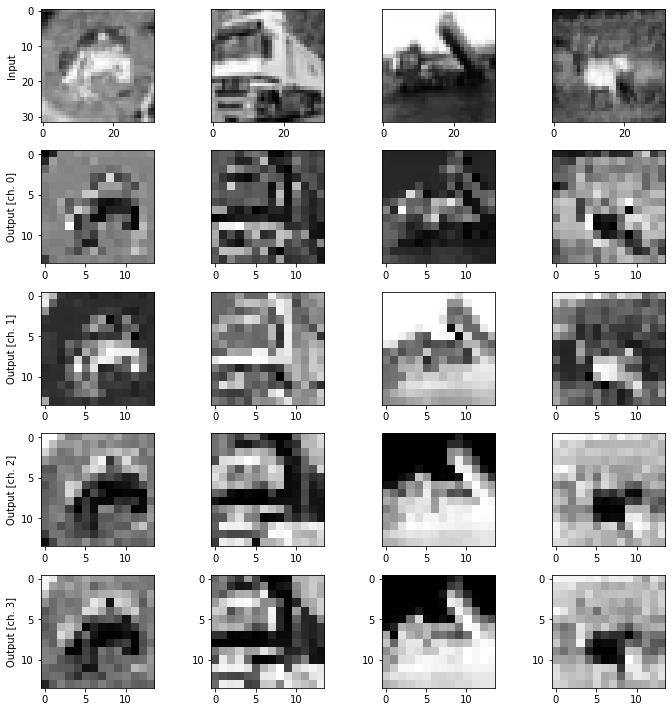

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

#**Hybrid quantum-classical model**

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='Adagrad',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# **Training**

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.5988 - accuracy: 0.1000 - val_loss: 2.2946 - val_accuracy: 0.1333
Epoch 2/30
13/13 - 0s - loss: 2.4148 - accuracy: 0.1400 - val_loss: 2.3076 - val_accuracy: 0.1000
Epoch 3/30
13/13 - 0s - loss: 2.3097 - accuracy: 0.2000 - val_loss: 2.3175 - val_accuracy: 0.1667
Epoch 4/30
13/13 - 0s - loss: 2.2358 - accuracy: 0.2000 - val_loss: 2.3242 - val_accuracy: 0.1667
Epoch 5/30
13/13 - 0s - loss: 2.1769 - accuracy: 0.2400 - val_loss: 2.3402 - val_accuracy: 0.1667
Epoch 6/30
13/13 - 0s - loss: 2.1254 - accuracy: 0.2400 - val_loss: 2.3516 - val_accuracy: 0.2000
Epoch 7/30
13/13 - 0s - loss: 2.0836 - accuracy: 0.3000 - val_loss: 2.3612 - val_accuracy: 0.1667
Epoch 8/30
13/13 - 0s - loss: 2.0468 - accuracy: 0.2800 - val_loss: 2.3731 - val_accuracy: 0.1667
Epoch 9/30
13/13 - 0s - loss: 2.0109 - accuracy: 0.3000 - val_loss: 2.3836 - val_accuracy: 0.1333
Epoch 10/30
13/13 - 0s - loss: 1.9836 - accuracy: 0.3400 - val_loss: 2.3919 - val_accuracy: 0.1333
Epoch 11/30
13/13 -

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/30
13/13 - 0s - loss: 2.5663 - accuracy: 0.1000 - val_loss: 2.5427 - val_accuracy: 0.0000e+00
Epoch 2/30
13/13 - 0s - loss: 2.3390 - accuracy: 0.1200 - val_loss: 2.5757 - val_accuracy: 0.0333
Epoch 3/30
13/13 - 0s - loss: 2.2540 - accuracy: 0.2400 - val_loss: 2.5912 - val_accuracy: 0.0000e+00
Epoch 4/30
13/13 - 0s - loss: 2.1818 - accuracy: 0.2400 - val_loss: 2.5484 - val_accuracy: 0.0667
Epoch 5/30
13/13 - 0s - loss: 2.1105 - accuracy: 0.2800 - val_loss: 2.5949 - val_accuracy: 0.0333
Epoch 6/30
13/13 - 0s - loss: 2.0406 - accuracy: 0.2600 - val_loss: 2.6099 - val_accuracy: 0.0000e+00
Epoch 7/30
13/13 - 0s - loss: 1.9947 - accuracy: 0.3400 - val_loss: 2.5686 - val_accuracy: 0.0333
Epoch 8/30
13/13 - 0s - loss: 1.9689 - accuracy: 0.3600 - val_loss: 2.6269 - val_accuracy: 0.0333
Epoch 9/30
13/13 - 0s - loss: 1.9128 - accuracy: 0.3400 - val_loss: 2.5989 - val_accuracy: 0.0333
Epoch 10/30
13/13 - 0s - loss: 1.8896 - accuracy: 0.3600 - val_loss: 2.6130 - val_accuracy: 0.0333
Epoch 1

# **Results**

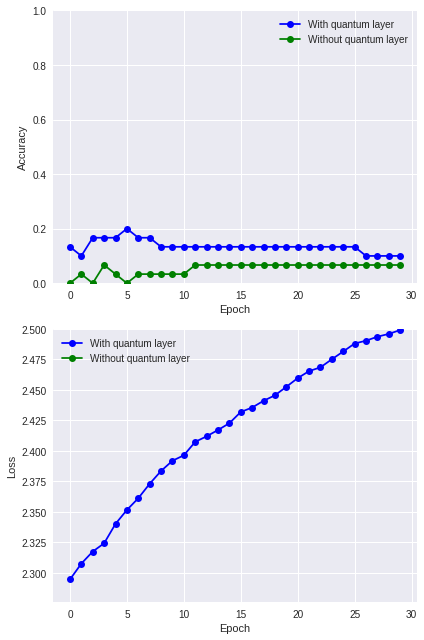

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
